<a href="https://colab.research.google.com/github/ChandrimaDam/CVPR/blob/main/APPLE_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install shap yfinance

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
dataset_path = "/content/drive/MyDrive/Stock_Project_Dataset"

# List all CSV files
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
csv_files

['META_monthly.csv',
 'GOOGLE_monthly.csv',
 'APPLE_monthly.csv',
 'META_weekly.csv',
 'NETFLIX_monthly.csv',
 'AMAZON_monthly.csv',
 'GOOGLE_weekly.csv',
 'AMAZON_weekly.csv',
 'NETFLIX_weekly.csv',
 'APPLE_weekly.csv',
 'META_daily.csv',
 'GOOGLE_daily.csv',
 'NETFLIX_daily.csv',
 'AMAZON_daily.csv',
 'APPLE_daily.csv']

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import shap
import warnings
warnings.filterwarnings("ignore")

In [12]:
DATA_PATH = "/content/Stock_Project_Dataset/APPLE_daily.csv"
df = pd.read_csv(DATA_PATH)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Stock_Project_Dataset/APPLE_daily.csv'

In [16]:
import os

csv_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

csv_files

['/content/drive/MyDrive/Stock_Project_Dataset/META_monthly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/GOOGLE_monthly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/APPLE_monthly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/META_weekly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/NETFLIX_monthly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/AMAZON_monthly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/GOOGLE_weekly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/AMAZON_weekly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/NETFLIX_weekly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/APPLE_weekly.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/META_daily.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/GOOGLE_daily.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/NETFLIX_daily.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/AMAZON_daily.csv',
 '/content/drive/MyDrive/Stock_Project_Dataset/APPLE_daily.csv']

In [17]:
DATA_PATH = "/content/drive/MyDrive/Stock_Project_Dataset/APPLE_daily.csv"
df = pd.read_csv(DATA_PATH)

In [18]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.098389,0.098817,0.098389,0.098389,469033600,0.098389
1,1980-12-15,0.093684,0.093684,0.093256,0.093256,175884800,0.093256
2,1980-12-16,0.086839,0.086839,0.086412,0.086412,105728000,0.086412
3,1980-12-17,0.088550,0.088978,0.088550,0.088550,86441600,0.088550
4,1980-12-18,0.091118,0.091545,0.091118,0.091118,73449600,0.091118


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11380 entries, 0 to 11379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11380 non-null  object 
 1   Open       11380 non-null  float64
 2   High       11380 non-null  float64
 3   Low        11380 non-null  float64
 4   Close      11380 non-null  float64
 5   Adj Close  11380 non-null  int64  
 6   Volume     11380 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 622.5+ KB


In [26]:
if 'Date' in df.columns:
    date_col = 'Date'
elif 'date' in df.columns:
    date_col = 'date'
elif 'Datetime' in df.columns:
    date_col = 'Datetime'
else:
    date_col = df.columns[0]  # assume first column is date

df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
df = df.sort_index()

In [27]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

In [30]:
df = pd.read_csv(DATA_PATH)

df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [33]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

data = df[features]

In [34]:
df.head()
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,11380.000000,11380.000000,11380.000000,11380.000000,1.138000e+04,11380.000000
mean,28.454190,28.762416,28.165337,28.476934,3.091712e+08,28.476934
std,58.723781,59.353922,58.148319,58.779969,3.332537e+08,58.779969
min,0.038072,0.038072,0.037645,0.037645,0.000000e+00,0.037645
25%,0.246718,0.253038,0.241129,0.245970,1.059464e+08,0.245970
50%,0.486876,0.495539,0.477045,0.486867,1.982344e+08,0.486867
75%,21.709653,21.934755,21.502349,21.728441,3.892399e+08,21.728441
max,286.200012,288.619995,283.299988,286.190002,7.421641e+09,286.190002


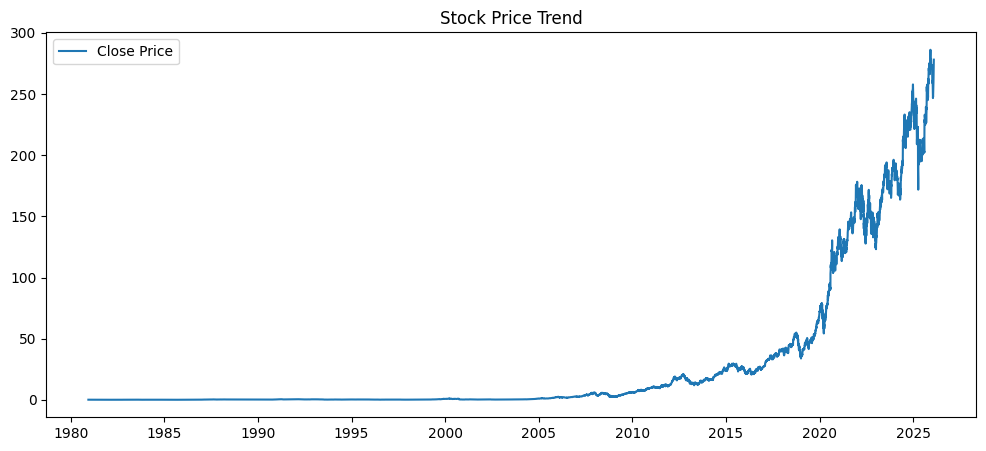

In [35]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close Price')
plt.title("Stock Price Trend")
plt.legend()
plt.show()

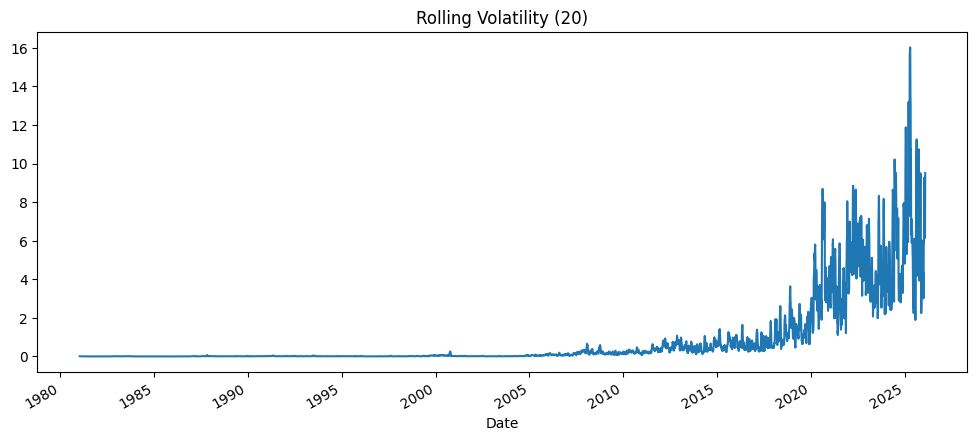

In [36]:
plt.figure(figsize=(12,5))
df['Close'].rolling(20).std().plot()
plt.title("Rolling Volatility (20)")
plt.show()

In [38]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [40]:
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 3])  # Close price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 30)

In [41]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [42]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.4112e-05 - val_loss: 7.7714e-06
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 4.9764e-06 - val_loss: 1.3324e-05
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4.8021e-06 - val_loss: 1.0298e-05
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.9313e-06 - val_loss: 6.1922e-06
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 4.0790e-06 - val_loss: 2.8965e-05
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 3.5739e-06 - val_loss: 1.5236e-05
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 3.5419e-06 - val_loss: 6.0157e-06
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.1122e-06 - val_loss: 2.3457e-05
Epoch 9/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 3.9160e-06 - val_loss: 5.4109e-06
Epoch 10/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3.1619e-06 - val_loss: 7.3476e-06
Epoch 11/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/

In [44]:
y_pred = model.predict(X_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [45]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.09197168025011558
MAE: 0.06211499045975721


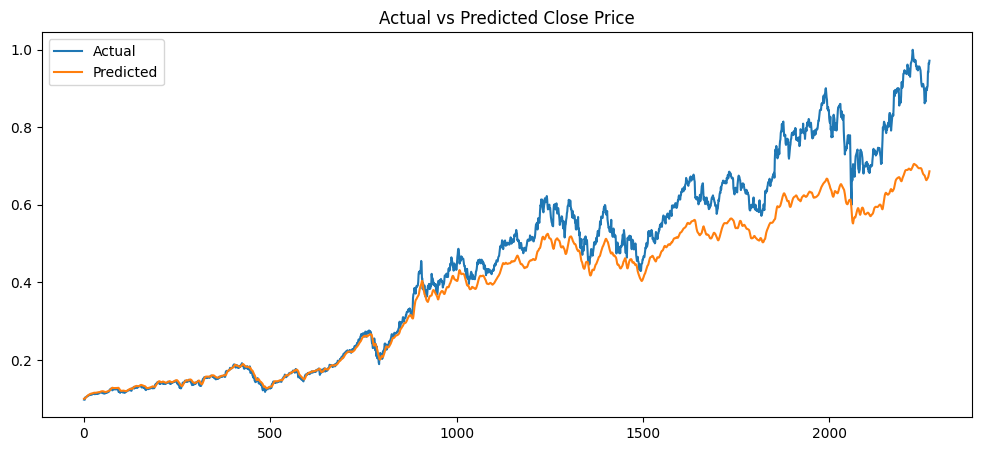

In [46]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.show()

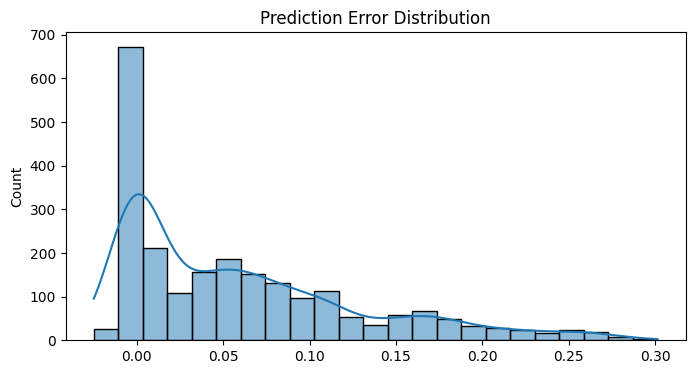

In [48]:
errors = y_test - y_pred.flatten()

plt.figure(figsize=(8,4))
sns.histplot(errors, kde=True)
plt.title("Prediction Error Distribution")
plt.show()

In [51]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
test_samples = X_test[:50]

In [53]:
def model_predict(x):
    return model.predict(x.reshape((-1, X_train.shape[1], X_train.shape[2])))

background_flat = background.reshape(background.shape[0], -1)
test_flat = test_samples.reshape(test_samples.shape[0], -1)

explainer = shap.KernelExplainer(model_predict, background_flat)
shap_values = explainer.shap_values(test_flat, nsamples=100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━